In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import ttest_ind, pearsonr
from tqdm import tqdm
from operator import itemgetter
from matplotlib import colors

from helpers import *

import warnings

# Ignoring warnings to improve code readability

warnings.filterwarnings("ignore")

# Resetting Matplotlib default settings
plt.rcdefaults()

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 20)

%load_ext autoreload
%autoreload 2

c:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
DATA_FOLDER = "../Data/"

actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genresCmu": parse_list,
    },
)

In [12]:
actors_load['actorDOB'] = pd.to_datetime(actors_load['actorDOB'], errors="coerce")  # TODO au début
actors_load['yearOfBirth'] = actors_load['actorDOB'].dt.year  #TODO au début

# Define a function to extract the minimum age from the ageAtMovieRelease dictionary
def get_min_age(x):
    if isinstance(x, dict):
        return min(x.values())
    else:
        return np.nan

def get_max_age(x):
    if isinstance(x, dict):
        return max(x.values())
    else:
        return np.nan


actors_after_1888 = actors_load[actors_load['yearOfBirth'] > 1888]
# Apply the function to the ageAtMovieRelease column
actors_after_1888['ageAtFirstMovie'] = actors_after_1888['ageAtMovieRelease'].apply(get_min_age)

actors_full_career = actors_after_1888[actors_after_1888['yearOfBirth'] < movies_load['releaseYear'].max() - 61]
# Apply the function to the ageAtMovieRelease column
actors_full_career['ageAtLastMovie'] = actors_full_career['ageAtMovieRelease'].apply(get_max_age)
# Calculate career length
actors_full_career['careerLength'] = actors_full_career['ageAtLastMovie'] - actors_full_career['ageAtFirstMovie']


print(f"Keeping all actors with a full career, we have {actors_full_career.size} actors")

Keeping all actors with a full career, we have 380160 actors


In [13]:
actors_full_career.head()

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,fbID,ageAtMovieRelease,category,winner,numMovies,yearOfBirth,ageAtFirstMovie,ageAtLastMovie,careerLength
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1,1928.0,67.0,67.0,0.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52,1930.0,28.0,72.0,44.0
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.74,NaN,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48,1920.0,28.0,69.0,41.0
6,/m/011_24,Les Brown,M,1912-03-14,NaN,NaN,"[/m/02stxk, /m/09n9rnb]","{'/m/02stxk': 50.0, '/m/09n9rnb': 30.0}",NaN,NaN,2,1912.0,30.0,50.0,20.0
8,/m/011_3s,Lily Tomlin,F,1939-09-01,1.73,NaN,"[/m/027qjyd, /m/028kj0, /m/02phv19, /m/02q3fdr...","{'/m/027qjyd': 52.0, '/m/028kj0': 52.0, '/m/02...",NaN,NaN,27,1939.0,37.0,68.0,31.0


In [50]:
from collections import Counter

max_career_length = int(actors_full_career['careerLength'].max())
print(f"Max career length: {max_career_length}")
actors_full_career.dropna(subset=['ageAtMovieRelease'], inplace=True)

def get_profile_sequence(x, max_career_length):
    age_at_first_movie = float(x.ageAtFirstMovie)  # Convert to integer

    age_list = []
    for value in x.ageAtMovieRelease.values():
        age_list.append(float(value) - age_at_first_movie)
    age_list.sort()

    # Count the number of movies for each age
    movie_count = Counter(age_list)

    # Create a list of size max of career length - min of career length + 1
    # and fill it with zeros
    profile_sequence = [0] * (max_career_length + 1)

    # Fill the list with the number of movies for each age
    for key, value in movie_count.items():
        profile_sequence[int(key)] = value

    return profile_sequence

actors_full_career['profileSequence'] = actors_full_career.apply(lambda x: get_profile_sequence(x, max_career_length), axis=1)

Max career length: 90


In [51]:
actors_full_career.head()

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,fbID,ageAtMovieRelease,category,winner,numMovies,yearOfBirth,ageAtFirstMovie,ageAtLastMovie,careerLength,profileSequence
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1,1928.0,67.0,67.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52,1930.0,28.0,72.0,44.0,"[1, 0, 0, 0, 1, 2, 1, 1, 2, 1, 0, 3, 1, 0, 0, ..."
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.74,NaN,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48,1920.0,28.0,69.0,41.0,"[2, 1, 2, 2, 0, 0, 2, 3, 2, 1, 3, 0, 1, 3, 1, ..."
6,/m/011_24,Les Brown,M,1912-03-14,NaN,NaN,"[/m/02stxk, /m/09n9rnb]","{'/m/02stxk': 50.0, '/m/09n9rnb': 30.0}",NaN,NaN,2,1912.0,30.0,50.0,20.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,/m/011_3s,Lily Tomlin,F,1939-09-01,1.73,NaN,"[/m/027qjyd, /m/028kj0, /m/02phv19, /m/02q3fdr...","{'/m/027qjyd': 52.0, '/m/028kj0': 52.0, '/m/02...",NaN,NaN,27,1939.0,37.0,68.0,31.0,"[1, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [70]:
from sklearn.cluster import KMeans

# Get the profile sequences
profile_sequences = actors_full_career['profileSequence'].tolist()

# Convert the profile sequences to a numpy array
X = np.array(profile_sequences)

# Define the number of clusters
n_clusters = 5

# Initialize the K-means clustering algorithm
kmeans = KMeans(n_clusters=n_clusters)

# Fit the data to the K-means algorithm
kmeans.fit(X)

# Get the cluster labels for each profile sequence
cluster_labels = kmeans.labels_

# Add the cluster labels to the actors_full_career dataframe
actors_full_career['clusterLabel'] = cluster_labels

# Print the cluster labels
print(actors_full_career['clusterLabel'])


1         2
3         0
4         4
6         2
8         1
         ..
135413    0
135414    2
135415    1
135416    0
135418    2
Name: clusterLabel, Length: 22458, dtype: int32


clusterLabel
0      580
1     3520
2    17816
3       33
4      509
dtype: int64


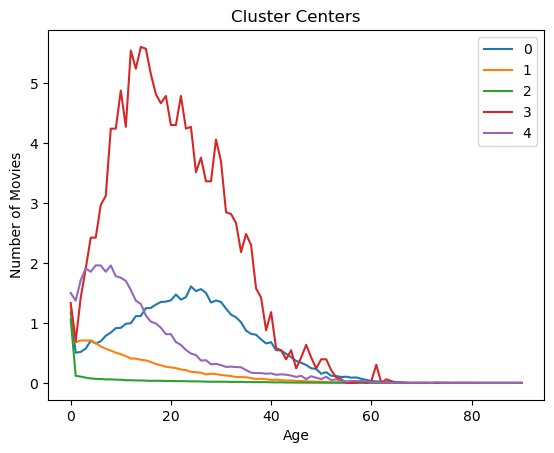

In [75]:
# Group the actors by cluster label
grouped_actors = actors_full_career.groupby('clusterLabel')

# Print the number of actors in each cluster
print(grouped_actors.size())

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

plt.plot(cluster_centers.T)
plt.xlabel('Age')
plt.ylabel('Number of Movies')
plt.title('Cluster Centers')
plt.legend(range(n_clusters))
plt.show()